In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import Counter
import os

In [2]:
linesup = {}

In [3]:
for fp in os.listdir('./Data/LinesUp/'):
    name = fp.split('.')[0]
    with open(os.path.join('./Data/LinesUp', fp), 'r') as f:
        lines = json.load(f)
        linesup[name] = lines

In [4]:
matchstats = {}

In [5]:
for fp in os.listdir('./Data/MatchesStats/'):
    name = fp.split('.')[0].split('match')[1]
    with open(os.path.join('./Data/MatchesStats', fp), 'r') as f:
        lines = json.load(f)
        matchstats[name] = lines

In [6]:
head2head = {}

In [7]:
for fp in os.listdir('./Data/Head2Head2021/'):
    name = fp.split('.')[0]
    with open(os.path.join('./Data/Head2Head2021/', fp), 'r') as f:
        lines = json.load(f)
        head2head[name] = lines

In [8]:
scores = pd.read_csv('./PreprocessedData/new_player.csv')

In [9]:
scores.columns

Index(['Unnamed: 0', 'touches_freq', 'info.age', 'info.info.position',
       'goals_conceded_rate', 'playerId', 'losses_rate', 'head_clearance_rate',
       'ball_recovery_rate', 'goals_rate', 'info.nationalTeam.country',
       'info.name.display', 'outfielder_block_rate', 'big_chance_created_rate',
       'error_lead_to_goal_rate', 'draws_rate', 'last_man_tackle_rate',
       'att_pen_goal_rate', 'wins_rate', 'total_long_balls_freq', 'saves_rate',
       'effective_clearance_rate', 'big_chance_missed_rate',
       'clean_sheet_rate', 'total_scoring_att_rate',
       'ontarget_scoring_att_rate', 'interception_rate',
       'error_lead_to_shot_rate', 'goal_assist_rate', 'big_chance_scored_rate',
       'own_goals_rate', 'total_contest_freq', 'att_freekick_goal_rate',
       'total_pass_freq', 'appearances_rate', 'id', 'total_tackle_freq',
       'teamid', 'penalty_rate', 'duel_rate', 'contest_rate', 'tackle_rate',
       'touch_rate', 'aerial_rate', 'fiftyfifty_rate', 'pass_rate',
   

In [10]:
score_cols = list(scores.columns)
new = []
for e in score_cols:
    if e[-4:] in ['rate', 'freq']:
        new.append(e)
score_cols = new

In [11]:
def cal_score(lineuplist):
    linupscore = scores.loc[scores['id'].isin(lineuplist)]
    linupscore = linupscore.mean()[score_cols].values
    return linupscore

In [58]:
matchs = []
for key, val in matchstats.items():
    
    t1 = val['entity']['teams'][0]['team']['id']
    n1 = val['entity']['teams'][0]['team']['name']
    t2 = val['entity']['teams'][1]['team']['id']
    n2 = val['entity']['teams'][1]['team']['name']
    res = val['entity']['outcome']
    
    
    if key in linesup.keys():
        lineup = linesup[key]
        l1 = lineup['team_1']
        l1 = [ele['player_id'] for ele in l1]
        
        score1 = cal_score(l1)
       
        l2 = lineup['team_2']
        l2 = [ele['player_id'] for ele in l2]
        score2 = cal_score(l2)
        assert(len(score1) == len(score2))
        
        if key in head2head.keys():
            h2h = head2head[key]
            count = h2h['matches_count']
            w1 = h2h['left_hand_club']['total_wins']
            w2 = h2h['right_hand_club']['total_wins']
            draw = h2h['draws']
            score1 = np.append(score1, w1/count)
            score2 = np.append(score2, w2/count)
        else:
            continue
    else:
        continue
#     print(val)
    week = val['entity']['gameweek']['gameweek']
    matchs.append({"matchid": key,"gameWeek": week, "res": res, "team1": t1, "team2": t2, "name1": n1, "name2": n2, "score1":score1, "score2":score2, "draw": draw/count})


In [59]:
len(matchs)

379

In [60]:
df = pd.json_normalize(matchs)

In [61]:
df['res'].value_counts()

A    153
H    143
D     83
Name: res, dtype: int64

In [66]:
df = df.sort_values(by=['gameWeek'])

In [71]:
traindf, testdf = df[:300], df[300:]

In [72]:
filter_cols = ['res', 'score1', 'score2', 'draw']

In [73]:
trainfeat, valfeat = traindf[filter_cols], testdf[filter_cols]

In [74]:
trainlabels, trainfeatures = trainfeat['res'], trainfeat[['score1', 'score2', 'draw']]
testlabels, testfeatures = valfeat['res'], valfeat[['score1', 'score2', 'draw']]

In [75]:
trainscore1 = trainfeatures['score1'].to_list()
trainscore2 = trainfeatures['score2'].to_list()
traindraw = trainfeatures['draw'].to_list()
trainscore1 = np.asarray(trainscore1)
trainscore2 = np.asarray(trainscore2)
traindraw = np.asarray(traindraw)



testscore1 = testfeatures['score1'].to_list()
testscore2 = testfeatures['score2'].to_list()
testdraw = testfeatures['draw'].to_list()
testscore1 = np.asarray(testscore1)
testscore2 = np.asarray(testscore2)
testdraw = np.asarray(testdraw)

In [20]:
score1.shape, score2.shape, draw.shape

((379, 40), (379, 40), (379,))

In [76]:
traindraw = np.expand_dims(traindraw, axis=1)
testdraw = np.expand_dims(testdraw, axis=1)

In [77]:
all_train_features = np.concatenate([trainscore1, trainscore2, traindraw], axis=1)
all_test_features = np.concatenate([testscore1, testscore2, testdraw], axis=1)

In [78]:
trainlabels = trainlabels.replace({'H': 0, 'D':1, 'A':2}).to_numpy()
testlabels = testlabels.replace({'H': 0, 'D':1, 'A':2}).to_numpy()

In [79]:
all_train_features.shape, all_test_features.shape, trainlabels.shape, testlabels.shape

((300, 81), (79, 81), (300,), (79,))

In [88]:
np.unique(trainlabels, return_counts=True), np.unique(testlabels, return_counts=True)

((array([0, 1, 2]), array([112,  70, 118])),
 (array([0, 1, 2]), array([31, 13, 35])))

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(all_features)

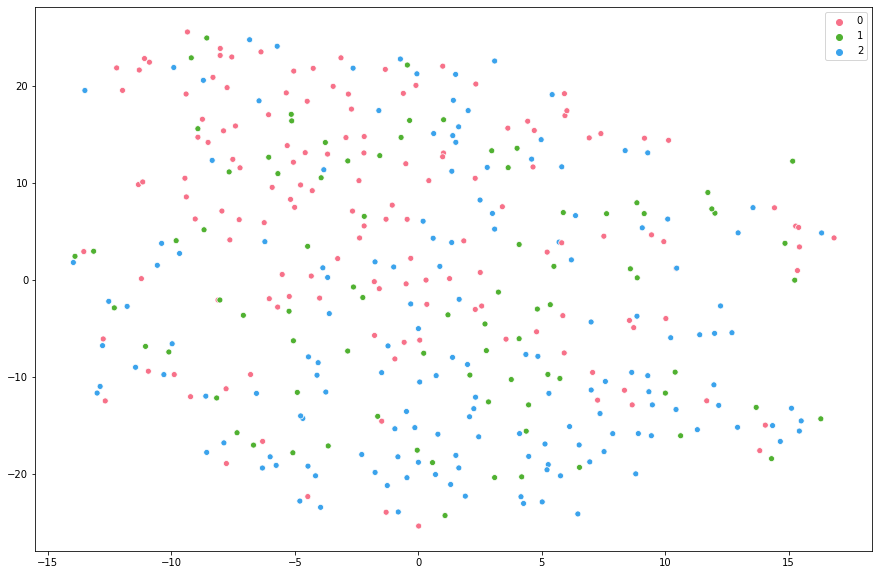

In [30]:
plt.figure(figsize=(15,10))
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=df.loc[rndperm,:],
#     legend="full",
#     alpha=0.3
# )
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=all_labels, palette=sns.color_palette("husl",3), legend='full',
               alpha=1.0)

In [132]:
# def standardization(x, axis=0):
#     m = np.mean(x, axis=axis)
#     st = np.std(x, axis=axis)
#     return (x-m)/st

In [32]:
# def shuffle(X, y):
#     indices = np.arange(X.shape[0])
#     np.random.shuffle(indices)
#     return np.squeeze(X[indices]), np.squeeze(y[indices])
# all_features, all_labels = shuffle(all_features, all_labels)

In [84]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import svm    
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [94]:
# trainX, testX, trainy, testy = train_test_split(all_features, all_labels, test_size=0.2, shuffle=True, stratify=all_labels)
trainX, testX, trainy, testy = all_train_features, all_test_features, trainlabels, testlabels

In [ ]:
train_test_split()

In [50]:
# trainX, testX = standardization(trainX), standardization(testX)

In [51]:
np.mean(trainX[:,0]), np.std(trainX[:, 0])

(0.18386124741112503, 0.07246681853206932)

In [95]:
np.unique(trainy, return_counts=True)

(array([0, 1, 2]), array([112,  70, 118]))

In [96]:
np.unique(testy, return_counts=True)

(array([0, 1, 2]), array([31, 13, 35]))

## Linear SVC

In [97]:
lin_clf = svm.LinearSVC()
lin_clf.fit(trainX, trainy)

/home/khangt1k25/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [98]:
accuracy_score(testy, lin_clf.predict(testX))

0.6582278481012658

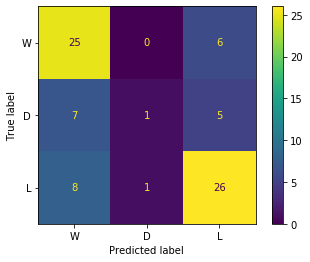

In [99]:
cm = confusion_matrix(testy,lin_clf.predict(testX))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W', 'D', 'L'])
disp.plot()
plt.show()

## Gaussian Naive bayes Classifier

In [100]:
# priors = [143,  83, 153]
# priors =[ele/sum(priors) for ele in priors]
# priors = [0.4, 0.2, 0.4]

In [104]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors=None)
gnb.fit(trainX, trainy)

GaussianNB(priors=None, var_smoothing=1e-09)

In [105]:
accuracy_score(testy, gnb.predict(testX))

0.6075949367088608

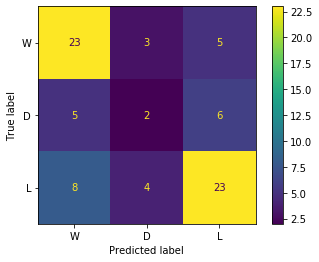

In [106]:
cm = confusion_matrix(testy, gnb.predict(testX))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W', 'D', 'L'])
disp.plot()
plt.show()

## Neural networks

In [126]:
class CustomeDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.y.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [127]:
trainSet = CustomeDataset(trainX, trainy)
testSet = CustomeDataset(testX, testy)

In [154]:
import torch
from sklearn.model_selection import StratifiedKFold
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,  int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)

In [ ]:
data_loader = DataLoader(
    dataset=TensorDataset(X,y),
    batch_sampler=StratifiedBatchSampler(y, batch_size=5)
)

In [173]:
trainLoader = torch.utils.data.DataLoader(trainSet, sampler=StratifiedBatchSampler(trainy, batch_size=15))
testLoader = torch.utils.data.DataLoader(testSet, batch_size=len(testSet))

In [174]:
for x in trainLoader:
    print(x[0].shape, x[1].shape)
    break

torch.Size([1, 15, 81]) torch.Size([1, 15])


In [175]:
class SimpleClassification(nn.Module):
    def __init__(self, num_feat, num_class):
        super(SimpleClassification, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_feat, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,  num_class),
        )
    def forward(self, x):
        output = self.net(x)
        output = torch.softmax(output, dim=1)
        return output

In [186]:
simpleHead = SimpleClassification(num_feat=81, num_class=3)
optimizer = torch.optim.Adam(simpleHead.parameters(), lr=0.0001)
# weight_class = [0.4, 0.2, 0.4]
# weight_class = [1-ele for ele in weight_class]
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight_class))

In [181]:
best_global = 0
for epoch in range(100):
    acc1 = 0 
    c = 0
    for i, batch in enumerate(trainLoader):
        inp, gt = batch
        inp = inp.float()
        gt = gt.long()
        gt = gt.squeeze(0)
        inp = inp.squeeze(0)
        pred = simpleHead(inp)
#         print(pred.shape, gt.shape)
    

        print(pred.shape, inp.shape)
        loss = criterion(pred, gt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(pred, dim=1)
        acc = torch.sum(pred == gt)
        acc = acc.item()/gt.shape[0]
        acc1 += acc
        c+=1
    print("epoch:", epoch)
    print("train acc:", acc1/c)
    
    acc1 = 0 
    c = 0
    for i, batch in enumerate(testLoader):
        inp, gt = batch
        inp = inp.float()
        gt = gt.long()
        gt = gt.squeeze(0)
        inp = inp.squeeze(0)

        pred = simpleHead(inp)
        pred = torch.argmax(pred, dim=1)
        
        acc = torch.sum(pred == gt)
        acc = acc.item()/pred.shape[0]
        acc1 += acc
        c+=1
    
    print("test acc:", acc1/c)
    
    
#     with open('./trainaeloss.txt', 'a') as f:
#         f.write(str(acc1/c))
#         f.write('\n')
    
    if (acc1/c > best_global):
        best_global = acc1/c
        print('saved')
        torch.save({"model":simpleHead.state_dict()}, './match_new2.pth')
    
    print("------------------------------")

torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
epoch: 0
train acc: 0.23666666666666664
test acc: 0.24050632911392406
saved
------------------------------
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([

torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
epoch: 9
train acc: 0.4166666666666668
test acc: 0.46835443037974683
saved
------------------------------
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([1

torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
epoch: 18
train acc: 0.5433333333333332
test acc: 0.6075949367088608
saved
------------------------------
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([1

torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
epoch: 29
train acc: 0.5633333333333332
test acc: 0.6582278481012658
------------------------------
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81]

torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
epoch: 39
train acc: 0.5666666666666667
test acc: 0.6582278481012658
------------------------------
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81]

epoch: 48
train acc: 0.5733333333333333
test acc: 0.6582278481012658
------------------------------
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
epoch: 49
train acc: 0.5700000000000001
test acc: 0.6708860759493671
-----------

torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
epoch: 62
train acc: 0.5666666666666667
test acc: 0.6708860759493671
------------------------------
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81]

torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
epoch: 72
train acc: 0.5733333333333333
test acc: 0.6582278481012658
------------------------------
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81]

torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
epoch: 83
train acc: 0.57
test acc: 0.6455696202531646
------------------------------
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([

torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
epoch: 93
train acc: 0.57
test acc: 0.6455696202531646
------------------------------
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([15, 3]) torch.Size([15, 81])
torch.Size([

In [182]:
checkpoint = torch.load('./match_new2.pth')
msg = simpleHead.load_state_dict(checkpoint['model']) 
msg

<All keys matched successfully>

In [187]:
testPredict = simpleHead(torch.from_numpy(testX).float())
testPredict = torch.argmax(testPredict, dim=1)
testPredict = testPredict.numpy()

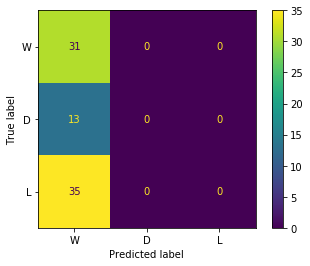

In [188]:
cm = confusion_matrix(testy, testPredict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W', 'D', 'L'])
disp.plot()
plt.show()

In [185]:
(testPredict == testy).sum()/testy.shape[0]

0.6708860759493671